# Landcover consensus

The purpose of this case study is to demonstrate how to retrieve data from a raster source, then operate on multiple layers at once to provide a landcover consensus map.

In [1]:
using SpeciesDistributionToolkit
using CairoMakie
CairoMakie.activate!(px_per_unit = 6.0)

In order to ensure that we do not load the full raster, we will start by getting a polygon (from the GADM.org database) corresponding to the country for which we want to produce the landcover consensus. Polygons are saved locally upon first request, so they are only downloaded once.

In [2]:
place = SpeciesDistributionToolkit.gadm("PRY");

The information we care about currently is to get the boundingbox of this polygon, which is *always* in WGS84.

In [3]:
extent = SpeciesDistributionToolkit.boundingbox(place)

(left = -62.642398834228516, right = -54.25859832763672, bottom = -27.60569953918457, top = -19.29520034790039)

We now decide which data source we want to use. Data sources are provided by the **SimpleSDMDatasets** package, but users can add their own sources. For this example, we will use the EarthEnv landcover data, but note that the Copernicus one is also available (although much, much larger).

In [4]:
provider = RasterData(EarthEnv, LandCover)

RasterData{EarthEnv, LandCover}(EarthEnv, LandCover)

To see which information is provided, we can call the `layers` function on this provider:

In [5]:
layers(provider)

12-element Vector{String}:
 "Evergreen/Deciduous Needleleaf Trees"
 "Evergreen Broadleaf Trees"
 "Deciduous Broadleaf Trees"
 "Mixed/Other Trees"
 "Shrubs"
 "Herbaceous Vegetation"
 "Cultivated and Managed Vegetation"
 "Regularly Flooded Vegetation"
 "Urban/Built-up"
 "Snow/Ice"
 "Barren"
 "Open Water"

We can now get the data we need from the provider. Note that we specify the layer we care about, as well as the bounding box of interest:

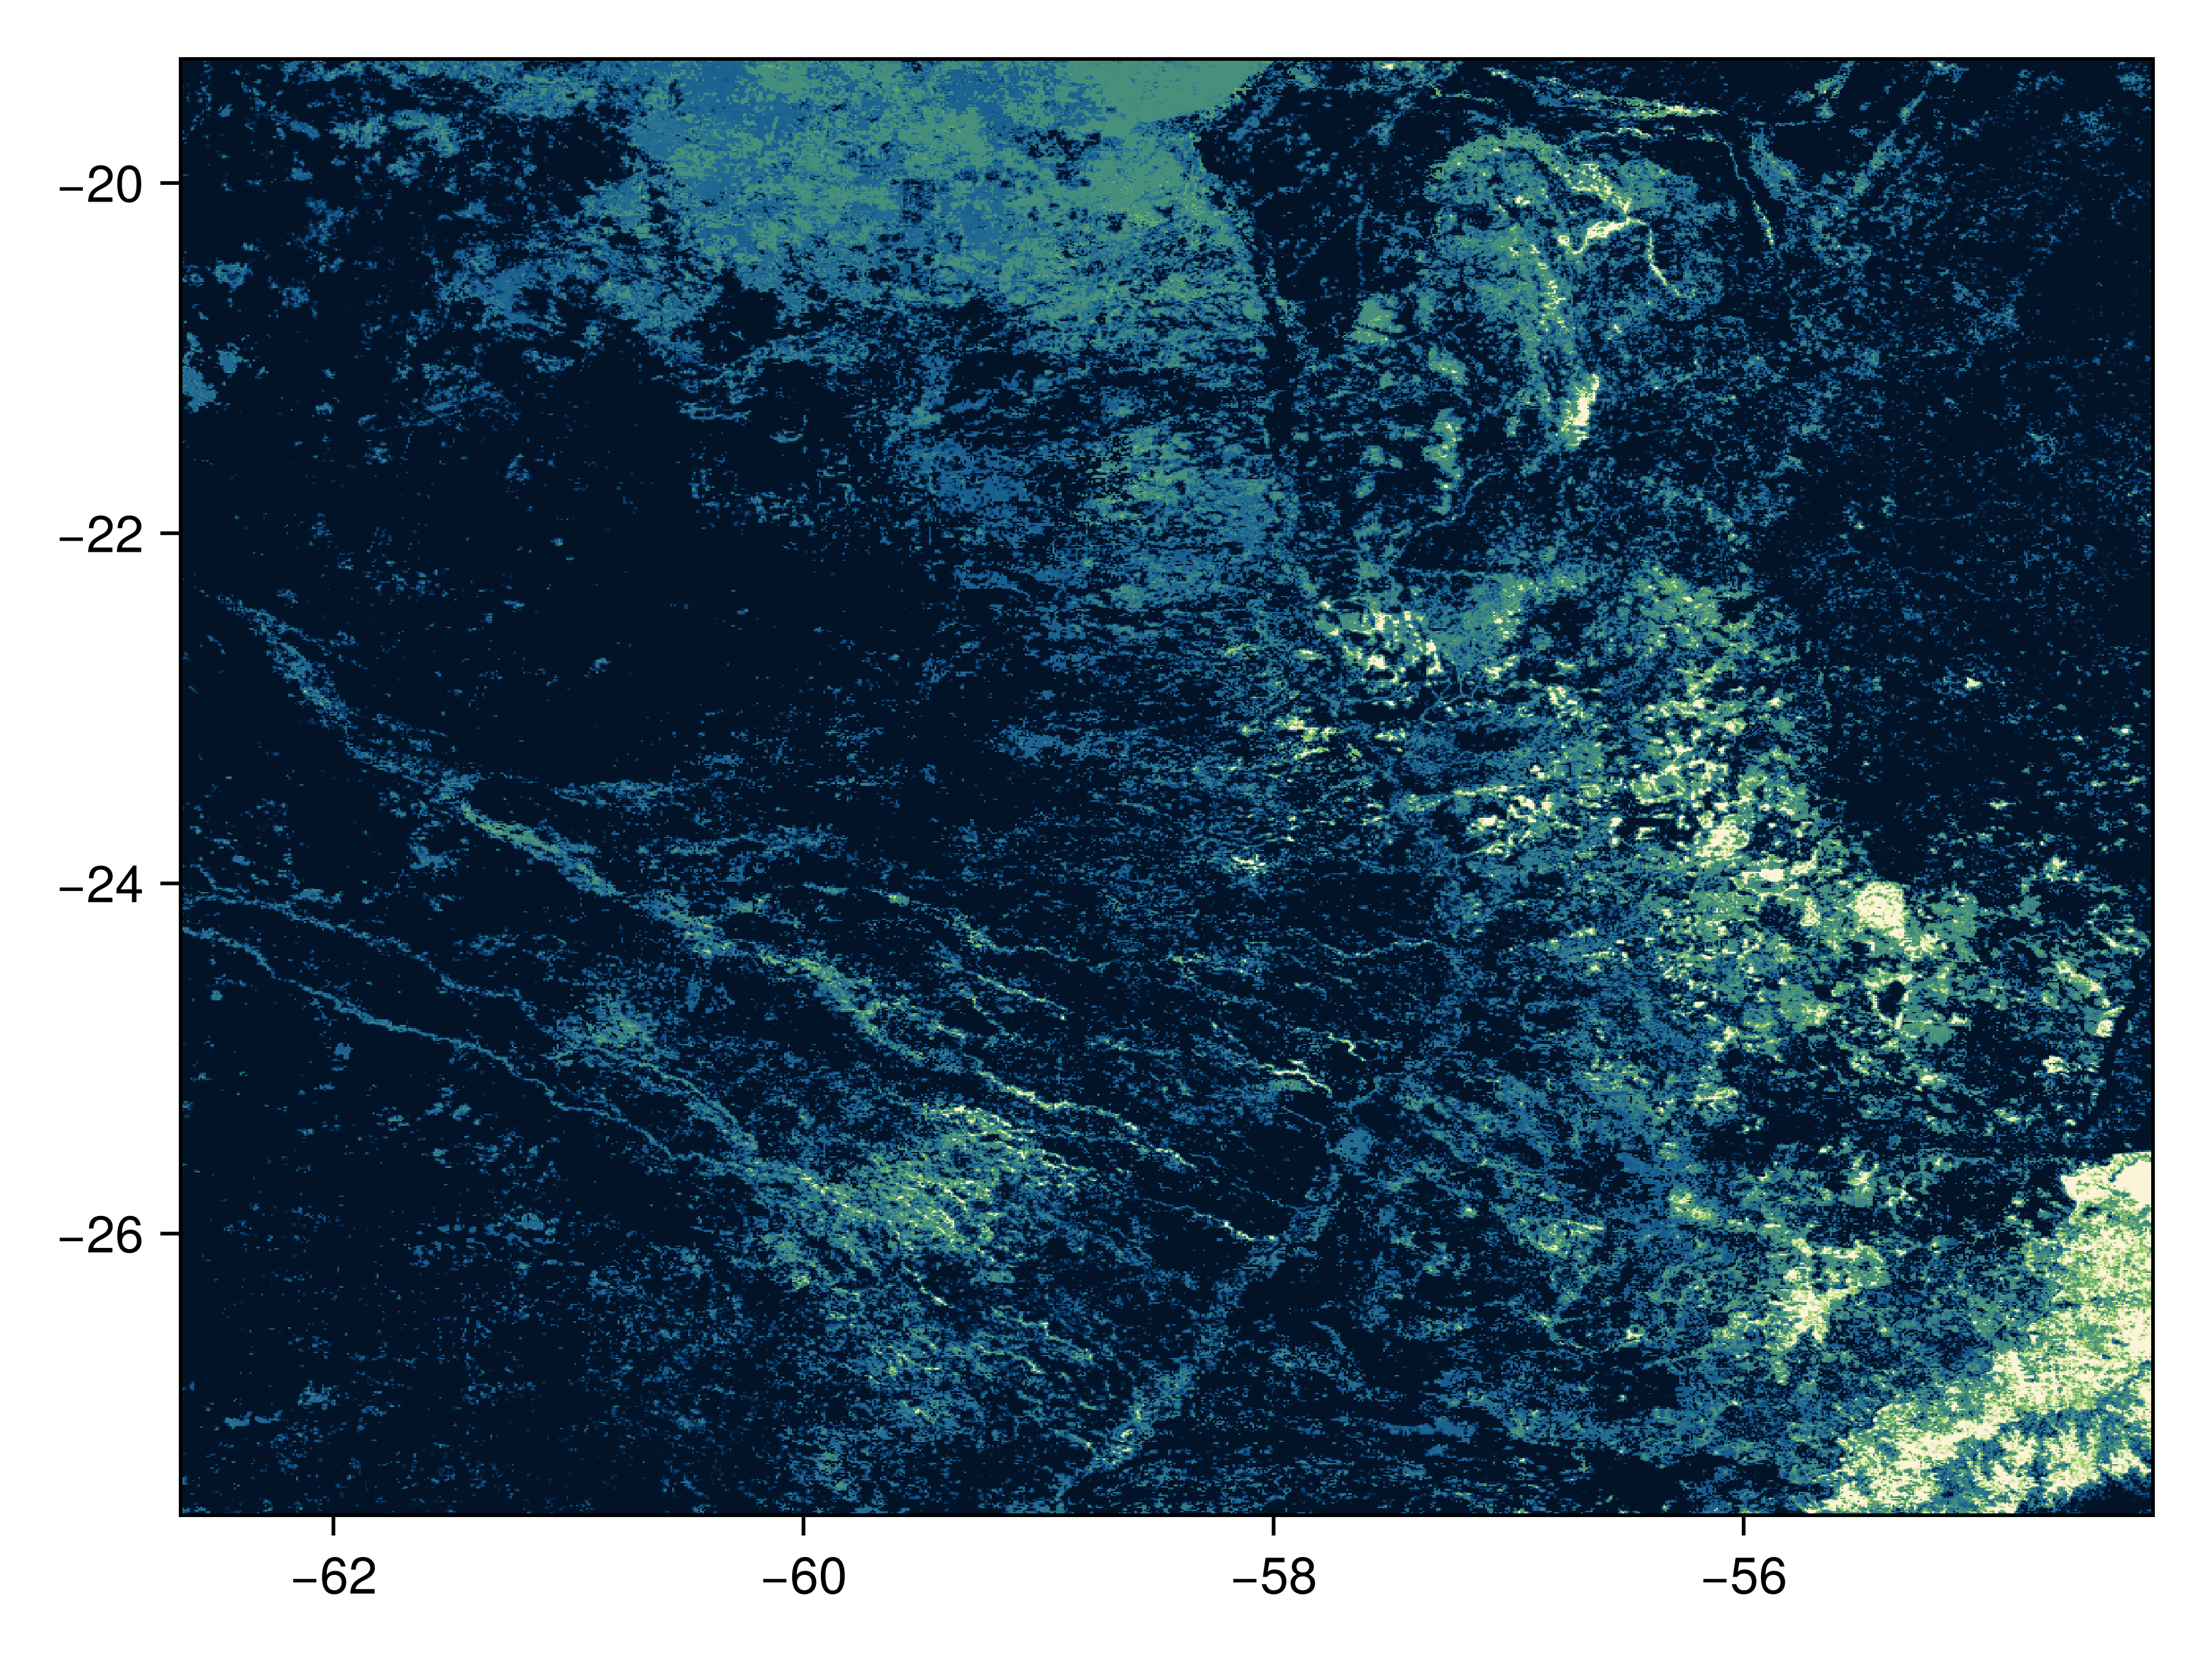

In [6]:
trees = SDMLayer(provider; layer="Evergreen Broadleaf Trees", extent...)
heatmap(trees, colormap=:navia)

Note that we have not masked this layer with our polygon, but we can do so rapidly. The `mask!` function *will* modify the layer passed as its first argument:

In [7]:
mask!(trees, place)

🗺️  A 998 × 1007 layer with 507651 UInt8 cells
   Projection: +proj=longlat +datum=WGS84 +no_defs

We can do a quick plot to check that the layer has indeed been clipped correctly:

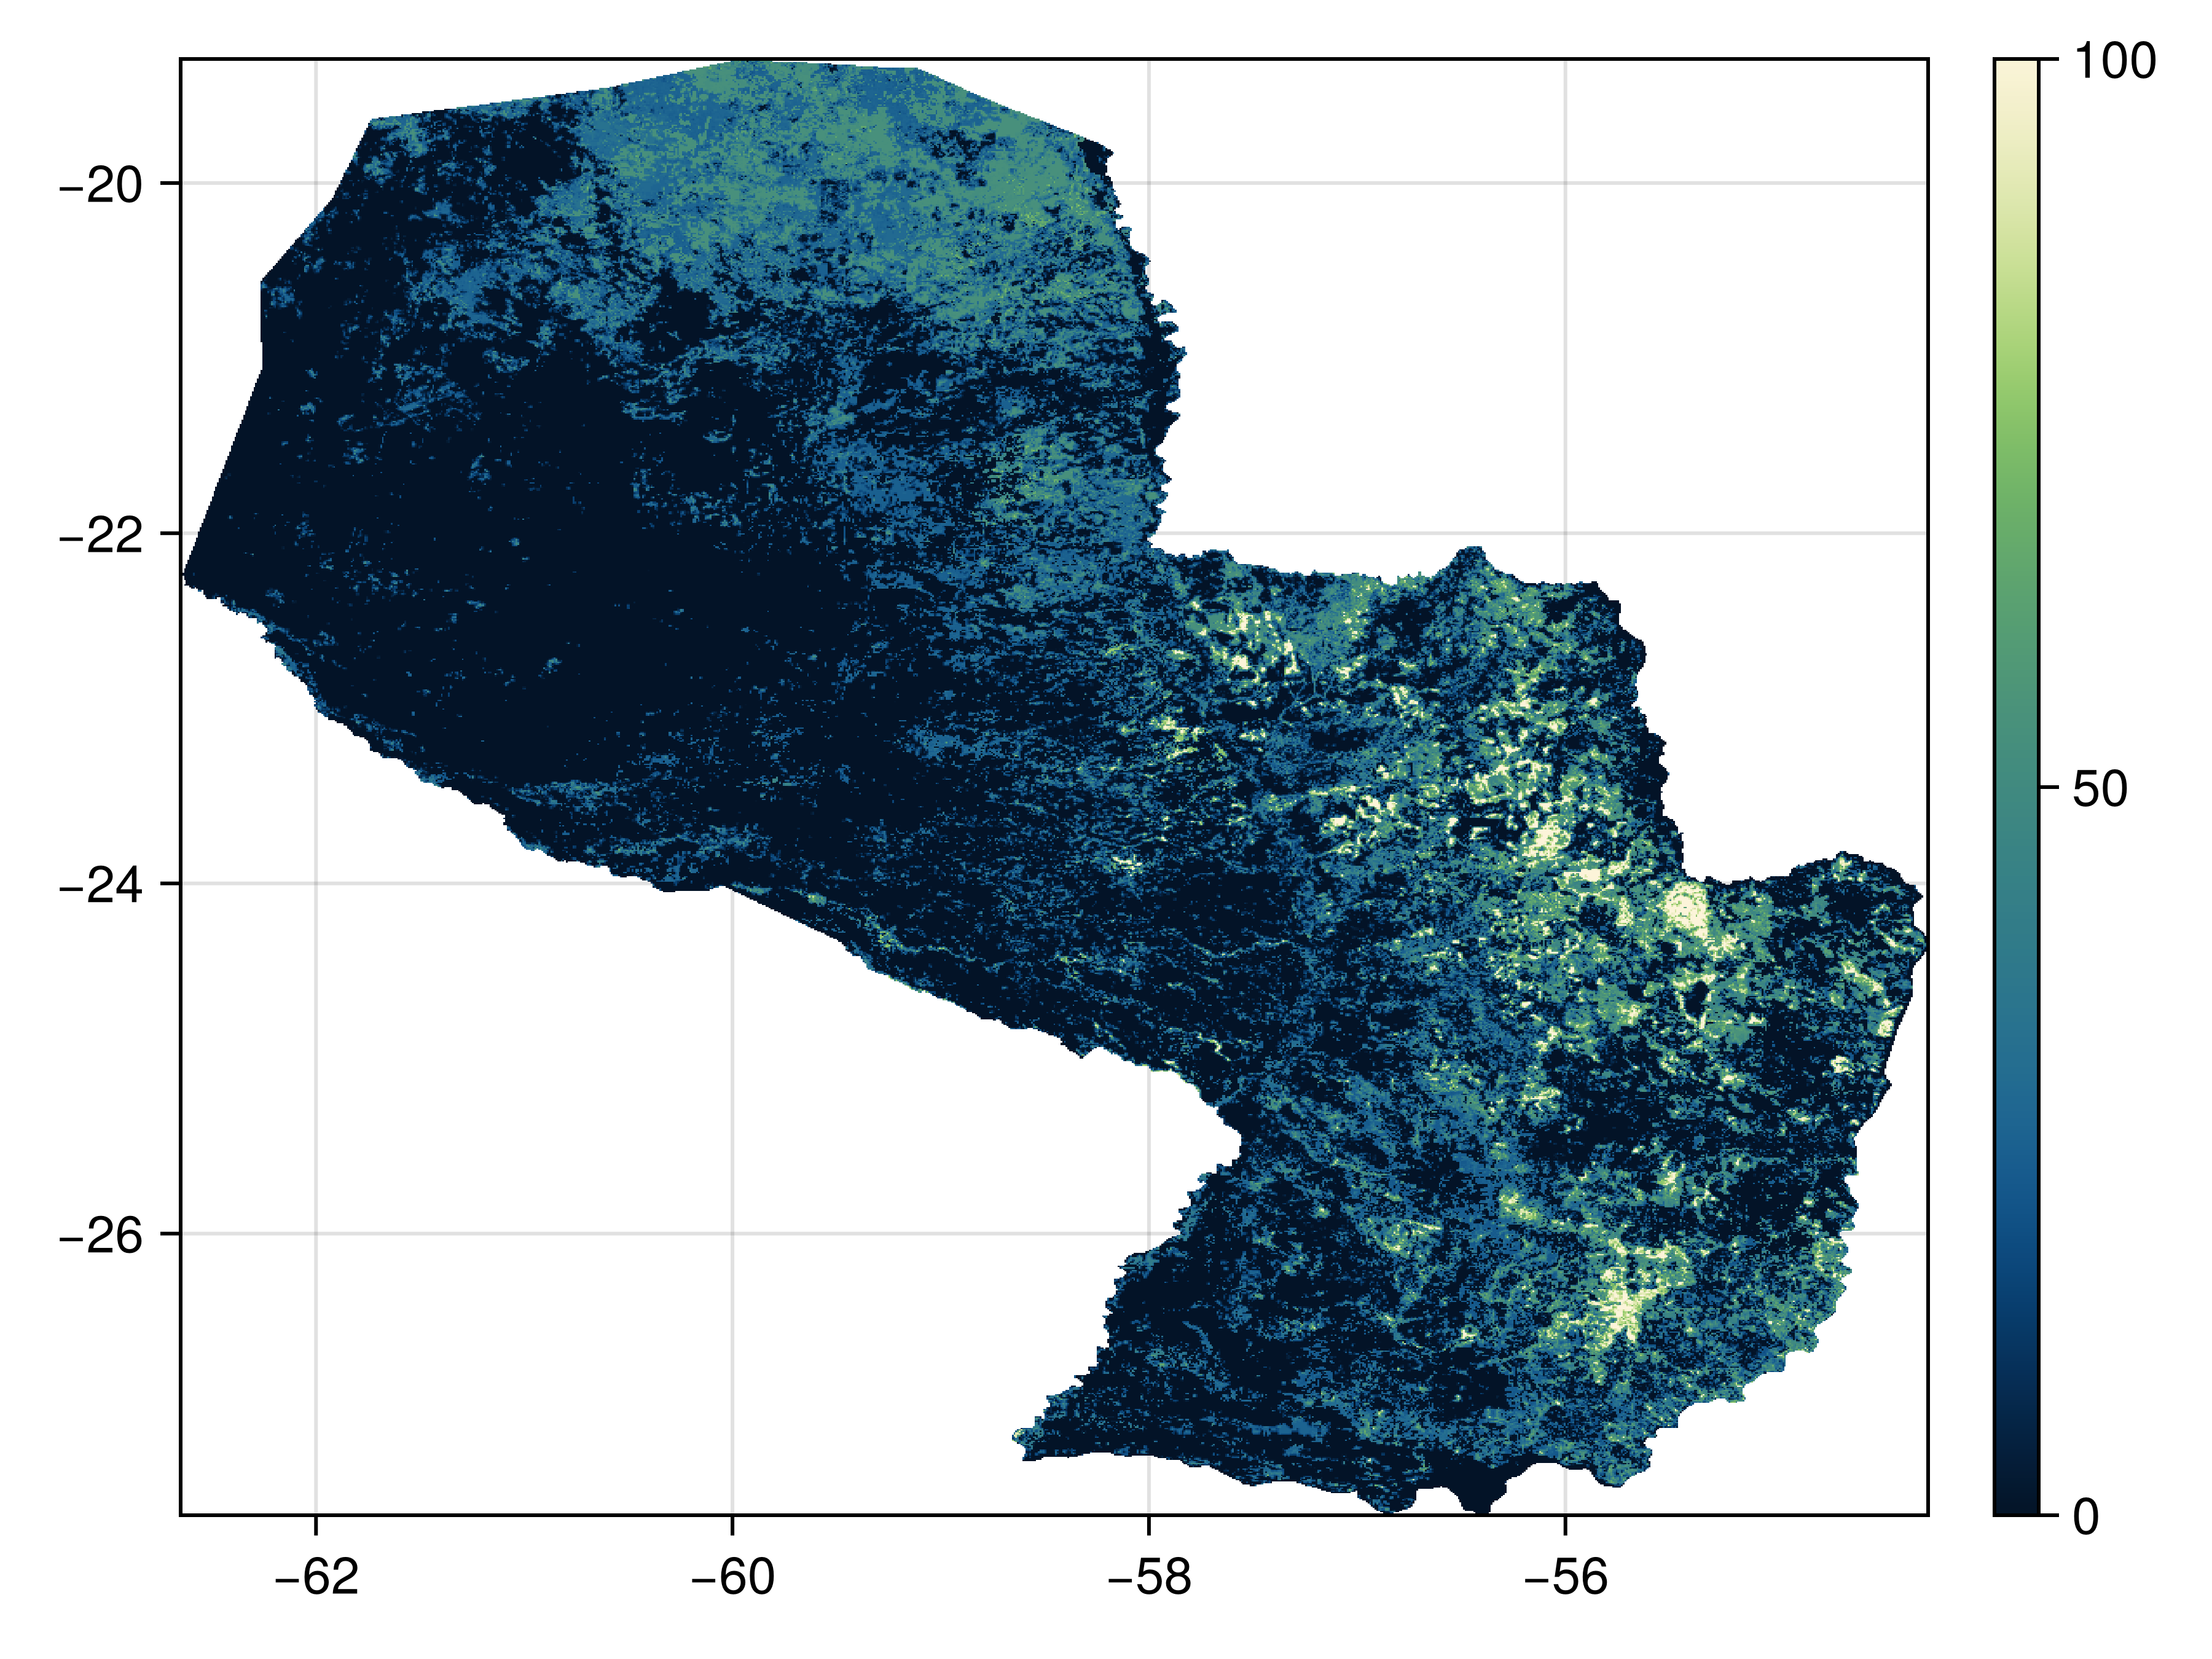

In [8]:
fg, ax, hm = heatmap(trees, colormap=:navia)
Colorbar(fg[1,2], hm)
current_figure()

Of course, we want to speed-up the process a little bit to operate on all layers, so we will use a list comprehension to collect all layers at once. We will, then, similarly mask them all at once.

In [9]:
luclasses = SDMLayer{UInt8}[SDMLayer(provider; layer=l, extent...) for l in layers(provider)]
mask!(luclasses, place)

12-element Vector{SDMLayer{UInt8}}:
 🗺️  A 998 × 1007 layer (507651 UInt8 cells)
 🗺️  A 998 × 1007 layer (507651 UInt8 cells)
 🗺️  A 998 × 1007 layer (507651 UInt8 cells)
 🗺️  A 998 × 1007 layer (507651 UInt8 cells)
 🗺️  A 998 × 1007 layer (507651 UInt8 cells)
 🗺️  A 998 × 1007 layer (507651 UInt8 cells)
 🗺️  A 998 × 1007 layer (507651 UInt8 cells)
 🗺️  A 998 × 1007 layer (507651 UInt8 cells)
 🗺️  A 998 × 1007 layer (507651 UInt8 cells)
 🗺️  A 998 × 1007 layer (507651 UInt8 cells)
 🗺️  A 998 × 1007 layer (507651 UInt8 cells)
 🗺️  A 998 × 1007 layer (507651 UInt8 cells)

We now have enough information to start building the consensus map. In order to do this, we want to look at *all* pixels in the layers, and figure out which one has the highest value.

The `mosaic` function will apply its first input (a function operating on a vector and returning an atomic value) to all cells with the same coordinate in its second argument, a vector of layers. In this case, we use the `argmax` function to identify which layer represents the most locally abundant land cover class:

In [10]:
consensus = mosaic(argmax, luclasses)

🗺️  A 998 × 1007 layer with 507651 Int64 cells
   Projection: +proj=longlat +datum=WGS84 +no_defs

We are now done with the analysis. The rest of the code is now data visualisation. First, we establish the color palette for the different land cover categories:

In [11]:
landcover_colors = ["#117733", "#668822", "#99BB55", "#55aa22", "#ddcc66", "#aaddcc", "#44aa88", "#88bbaa", "#bb0011", :aqua, "#FFEE88", "#5566AA"]

12-element Vector{Any}:
 "#117733"
 "#668822"
 "#99BB55"
 "#55aa22"
 "#ddcc66"
 "#aaddcc"
 "#44aa88"
 "#88bbaa"
 "#bb0011"
 :aqua
 "#FFEE88"
 "#5566AA"

We can collect the layer names to help with the map caption:

In [12]:
layernames = layers(provider)

12-element Vector{String}:
 "Evergreen/Deciduous Needleleaf Trees"
 "Evergreen Broadleaf Trees"
 "Deciduous Broadleaf Trees"
 "Mixed/Other Trees"
 "Shrubs"
 "Herbaceous Vegetation"
 "Cultivated and Managed Vegetation"
 "Regularly Flooded Vegetation"
 "Urban/Built-up"
 "Snow/Ice"
 "Barren"
 "Open Water"

Finally, we will collect the unique values stored in the consensus layer, to remove all the categories that are never the most locally abundant:

In [13]:
present = sort(unique(values(consensus)))

10-element Vector{Int64}:
  2
  3
  4
  5
  6
  7
  8
  9
 11
 12

Finally, we draw the figure (included in the main text of the article). The **SDT** package relies on **CairoMakie** as a backend:

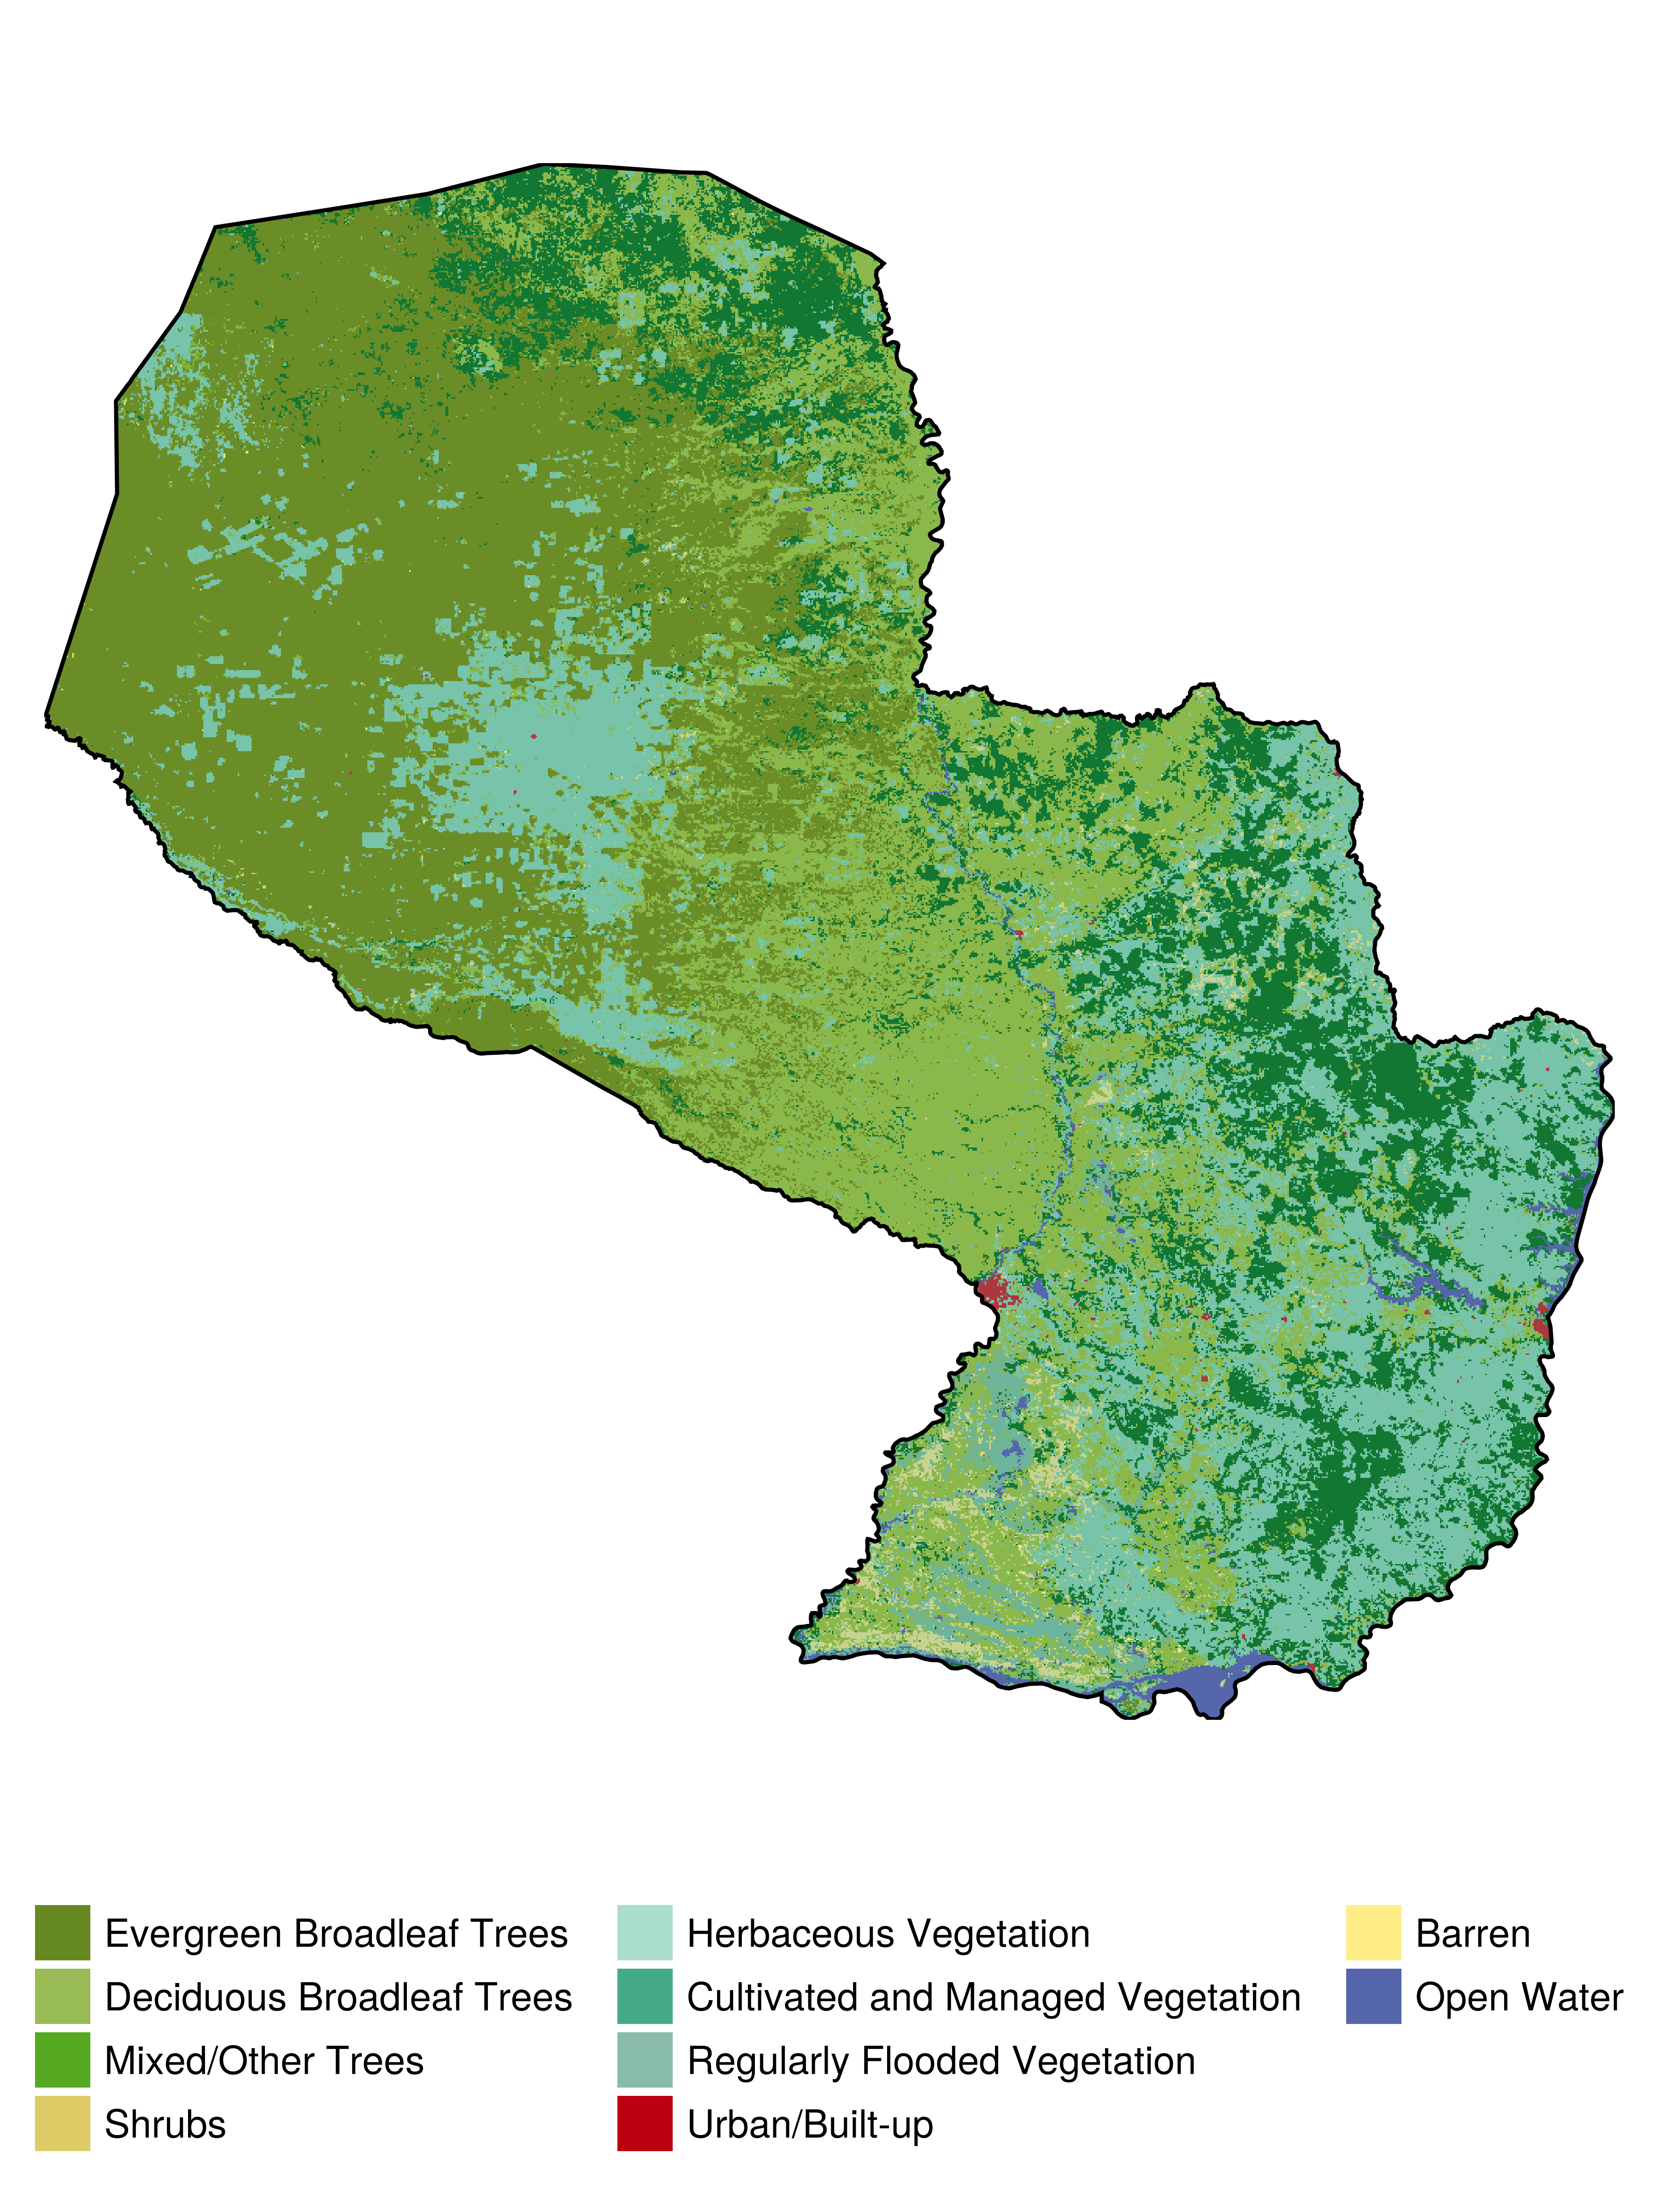

In [14]:
#| label: fig-landcover-consensus
#| fig-cap: "Land cover consensus (defined as the class with the strongest local representation) in the country of Paraguay. Only the classes that were most abundant in at least one pixel are represented. The code to produce this ﬁgure is available as Supp. Mat. 2."
fig = Figure(; size=(600, 800))
panel = Axis(fig[1, 1]; aspect = DataAspect())
heatmap!(panel, consensus; colormap = landcover_colors)
lines!(panel, place[1].geometry, color=:black)
tightlimits!(panel)
hidespines!(panel)
hidedecorations!(panel)
Legend(
    fig[2, 1],
    [PolyElement(; color = landcover_colors[i]) for i in present],
    layers(provider)[present];
    orientation = :horizontal,
    nbanks = 4,
    framevisible=false
)
fig